In [2]:
%matplotlib inline
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
import random
torch.manual_seed(0)
random.seed(0)


In [3]:
σ = 0.2
Δ = torch.tensor([2.0, 0.0])

def sample_p(n):
    y = torch.randn(n, 2)
    x = y + torch.randn_like(y) * σ
    return x, y

def sample_q(n):
    y = torch.randn(n, 2)
    x = y + torch.randn_like(y) * σ + Δ
    return x, y


In [17]:
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=2, latent_dim=2, hidden_dim=64):
        super().__init__()
        # encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # decoder (optional for visualization)
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = F.relu(self.fc2(z))
        return self.fc_out(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

# Instantiate VAE encoder and frozen anchor copy
latent_dim = 2
vae = VAE(input_dim=2, latent_dim=latent_dim)
vae_anchor = VAE(input_dim=2, latent_dim=latent_dim)
vae_anchor.load_state_dict(vae.state_dict())
vae_anchor.eval()
for p in vae_anchor.parameters(): p.requires_grad = False

# 셀 4: MI estimator 및 helpers
bce = nn.BCEWithLogitsLoss()
def estimate_iw_cos(z, y):
    t = (F.cosine_similarity(z, y, dim=-1))
    logZ = torch.log(torch.exp(t).mean())
    return t.mean() - logZ

def sample_p(batch):
    y = torch.randn(batch, 2)
    x = y + torch.randn_like(y)*σ
    return x, y

# FGSM attack helper
def fgsm_attack(x, grad, eps):
    return x + eps * grad.sign()

# 시각화 helper
def save_scatter(z_c, z_a, title):
    plt.figure(dpi=120)
    plt.scatter(z_c[:,0], z_c[:,1], s=4, alpha=0.6, label='clean')
    plt.scatter(z_a[:,0], z_a[:,1], s=4, alpha=0.6, label='adv')
    plt.title(title); plt.legend(); plt.axis('equal'); plt.show()

In [12]:
bce = nn.BCEWithLogitsLoss()

def estimate_iw_cos(z, y):
    t_xy = T_cos(z, y)                     # cos sim 벡터
    logZ = torch.log(torch.exp(t_xy).mean())
    return t_xy.mean() - logZ             # E[T] - log E[e^T]


Before Training:


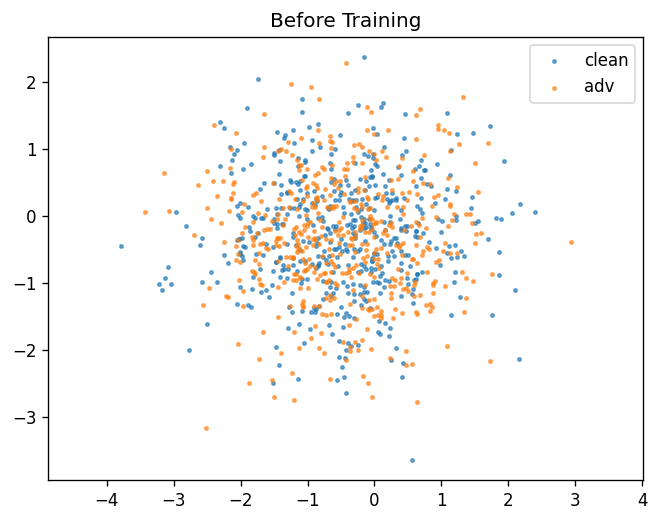

AttributeError: 'NoneType' object has no attribute 'sign'

In [18]:
# 셀 5: 훈련 루프 + MI 계산 + 시각화
steps, batch = 5000, 256
lr_vae, lr_d = 1e-3, 1e-3
eps_attack = 0.1

opt_vae = optim.Adam(vae.parameters(), lr=lr_vae)
opt_d   = optim.Adam(DNet().parameters(), lr=lr_d)

print('Before Training:')
x_c0, y0 = sample_p(500)
z_c0, _, _ = vae_anchor(x_c0)
z_a0, _, _ = vae(x_c0)
save_scatter(z_c0.detach(), z_a0.detach(), 'Before Training')

for step in range(1, steps+1):
    # 1) sample clean
    x_c, y = sample_p(batch)
    # 2) FGSM adversarial on VAE output
    x_adv = x_c.clone().detach().requires_grad_(True)
    z_adv, mu_adv, logvar_adv = vae(x_adv)
    logits = DNet()(z_adv.detach(), y)
    loss_ce = bce(logits, torch.ones(batch))
    loss_ce.backward()
    x_a = fgsm_attack(x_adv, x_adv.grad, eps_attack).detach()

    # 3) encode clean and adv with anchor and trainable VAE
    z_c_anchor, mu_c, logvar_c = vae_anchor(x_c)
    z_a, mu_a, logvar_a         = vae(x_a)

    # 4) D update
    dnet = DNet()
    opt_d.zero_grad()
    loss_d = bce(dnet(z_c_anchor.detach(), y), torch.ones(batch)) \
           + bce(dnet(z_a.detach(), y), torch.zeros(batch))
    loss_d.backward(); opt_d.step()

    # 5) VAE (encoder) update: MI + KL divergence
    iw = estimate_iw_cos(z_a, y)
    # KL terms
    kl_c = -0.5 * torch.sum(1 + logvar_c - mu_c.pow(2) - logvar_c.exp()) / batch
    kl_a = -0.5 * torch.sum(1 + logvar_a - mu_a.pow(2) - logvar_a.exp()) / batch
    loss_vae = iw.abs() + 0.1*(kl_c + kl_a)
    opt_vae.zero_grad(); loss_vae.backward(); opt_vae.step()

    if step % 1000 == 0:
        print(f"[{step}/{steps}] IW={iw.item():+.4f}, KL_clean={kl_c.item():.4f}, KL_adv={kl_a.item():.4f}")

print('After Training:')
x_c1, y1 = sample_p(500)
z_c1, _, _ = vae_anchor(x_c1)
z_a1, _, _ = vae(x_c1)
save_scatter(z_c1.detach(), z_a1.detach(), 'After Training')


SyntaxError: invalid character in identifier (3798924710.py, line 11)

Before adv mean tensor([-3.5704, -2.2800]) var tensor([21.0652, 20.4712])
Before clean mean tensor([-0.3914, -0.3826]) var tensor([400.7792, 401.1656])


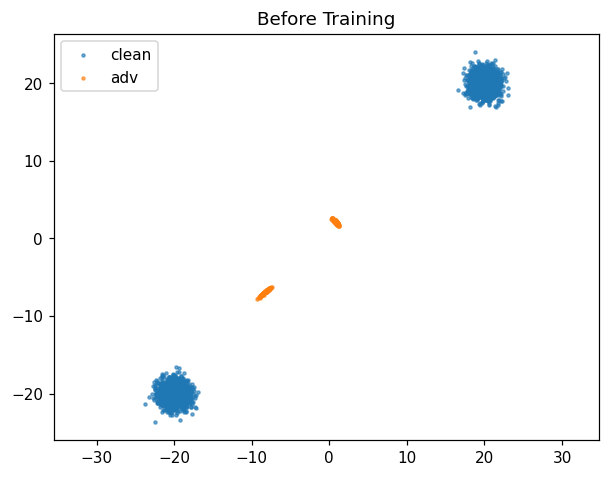

[1000] gap=0.0959, Iq_IW=+0.6271, Iq=+0.5312, KL=0.368, w̄=0.688


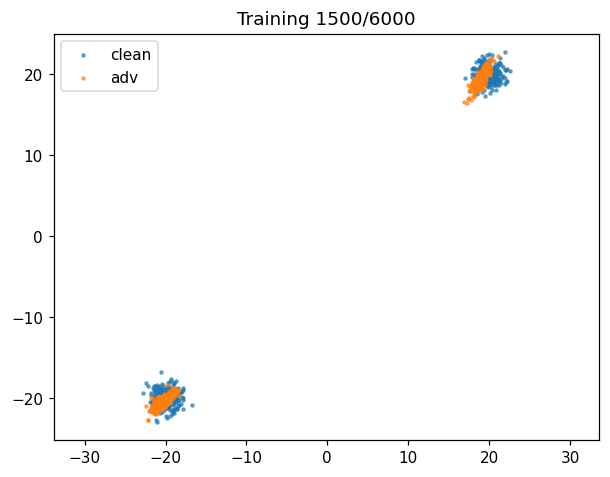

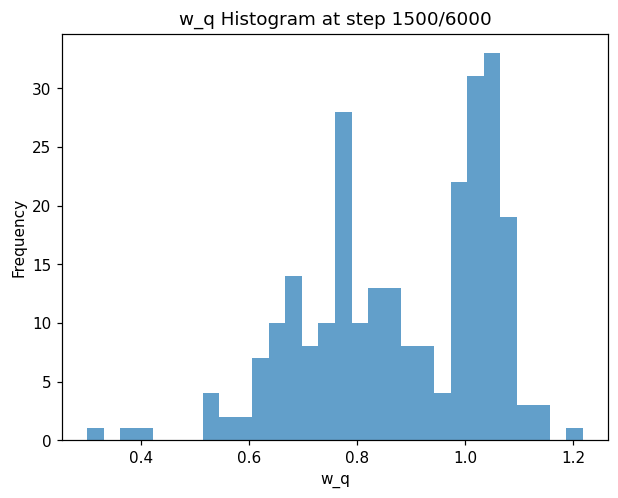

[2000] gap=0.0213, Iq_IW=+0.6365, Iq=+0.6152, KL=0.027, w̄=1.042


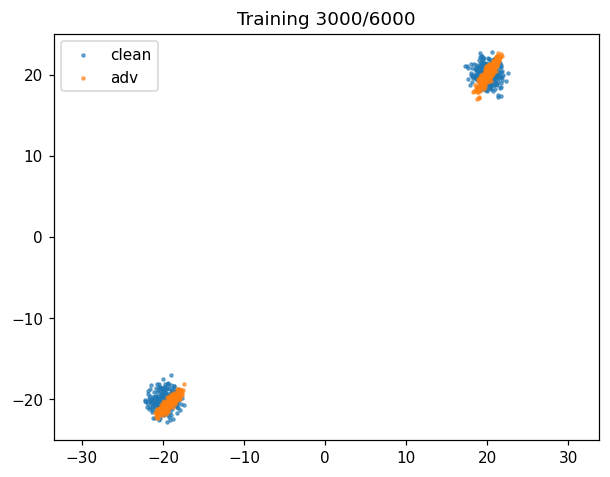

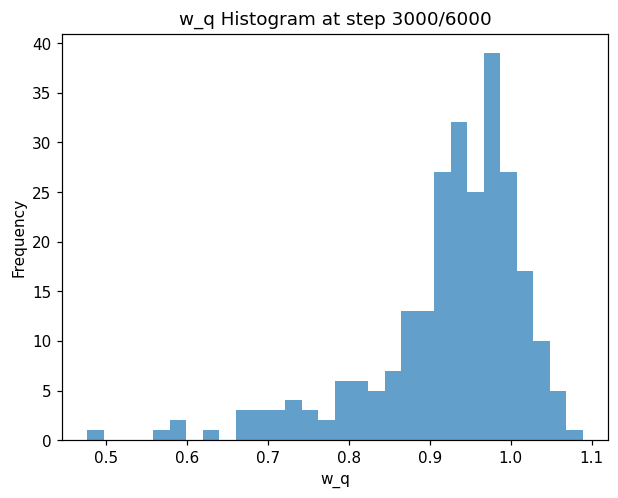

[3000] gap=0.0050, Iq_IW=+0.5597, Iq=+0.5547, KL=0.015, w̄=0.923
[4000] gap=-0.0019, Iq_IW=+0.5524, Iq=+0.5544, KL=0.006, w̄=1.018


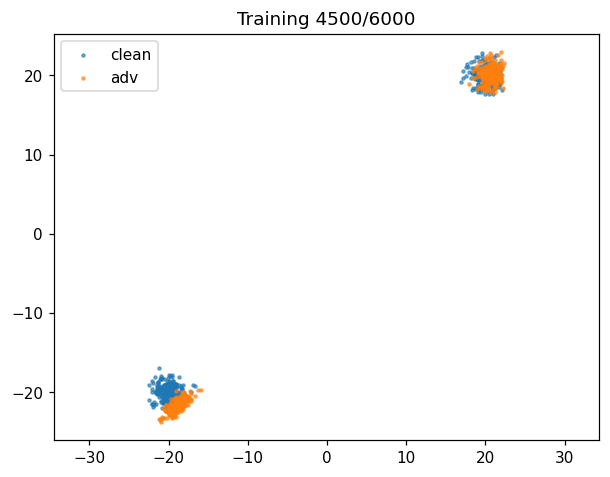

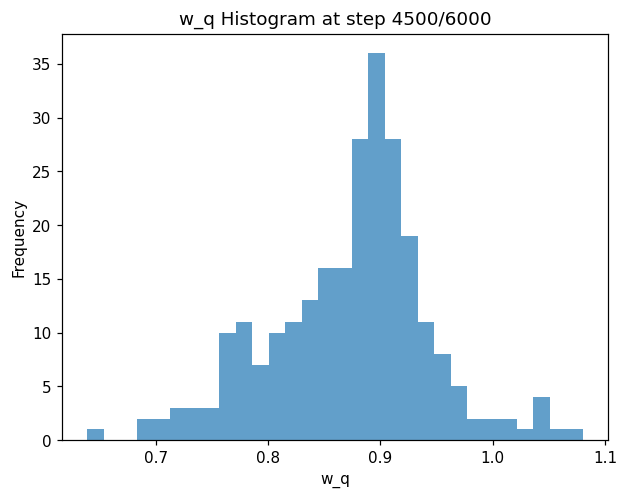

[5000] gap=0.0729, Iq_IW=+0.7007, Iq=+0.6278, KL=0.110, w̄=0.679


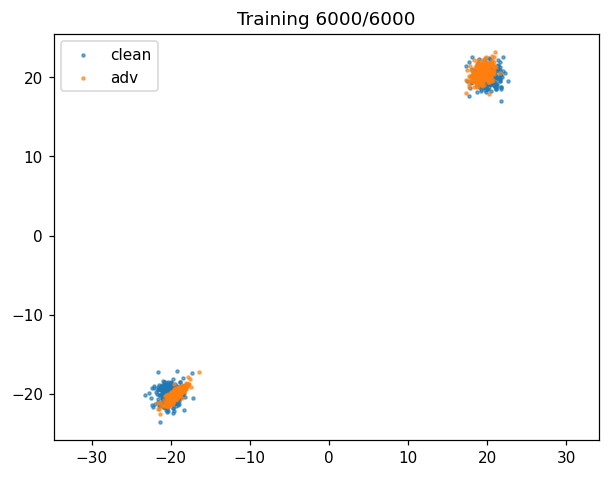

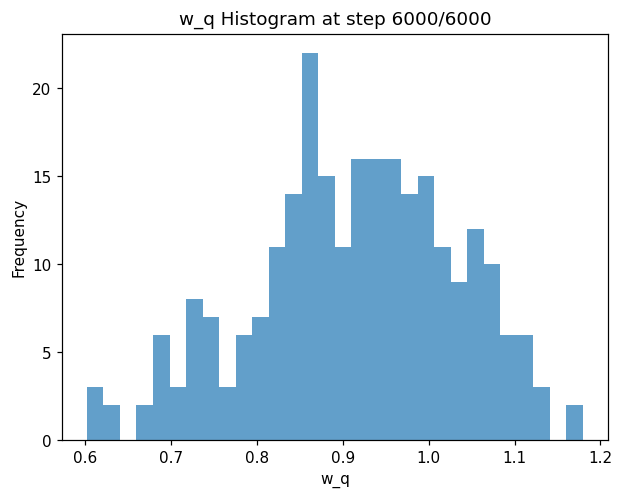

[6000] gap=0.0006, Iq_IW=+0.5554, Iq=+0.5548, KL=0.021, w̄=0.914


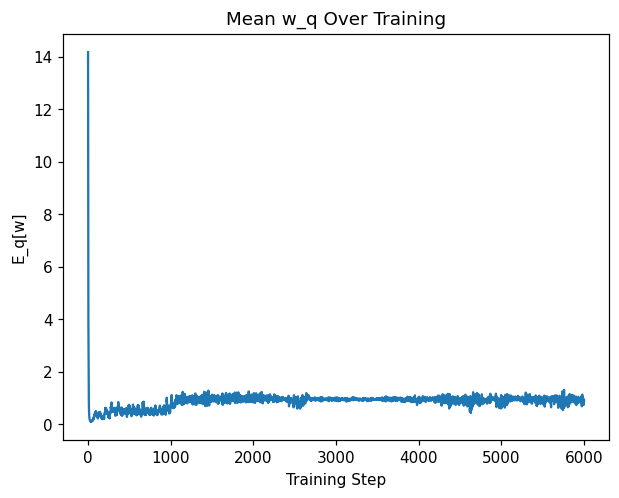

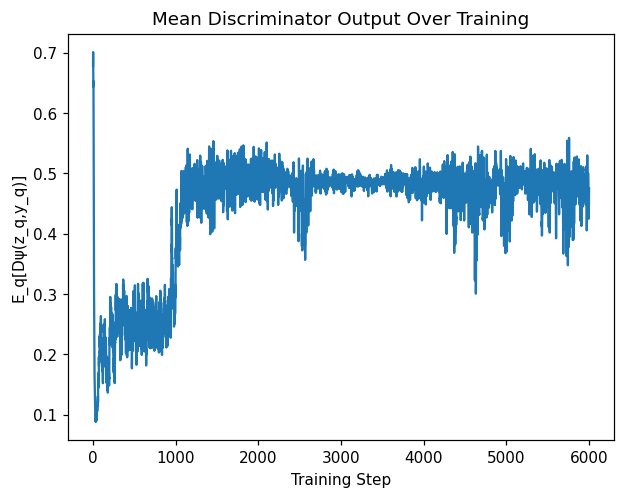

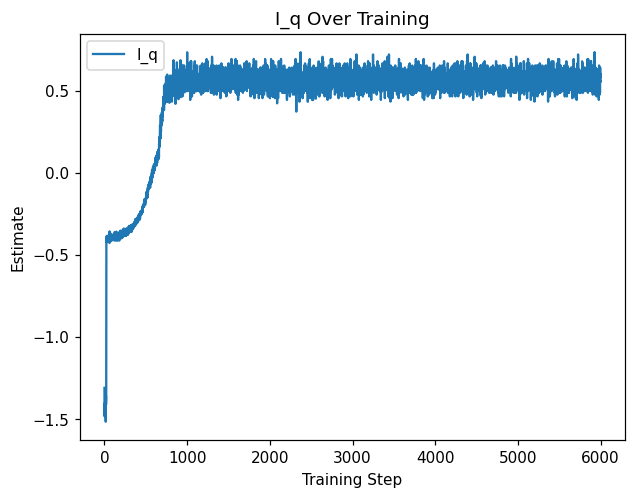

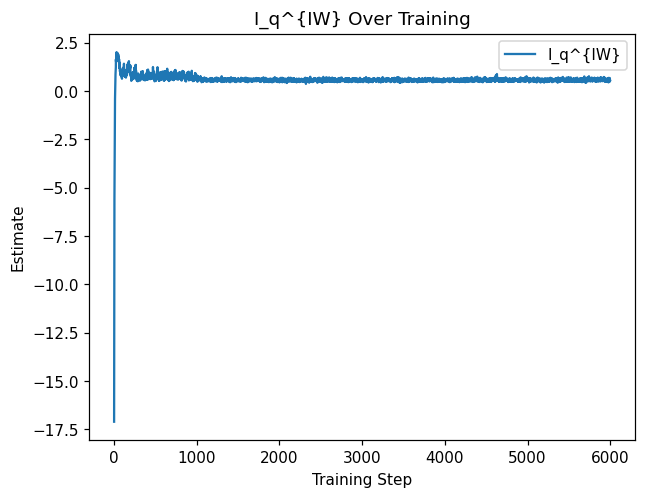

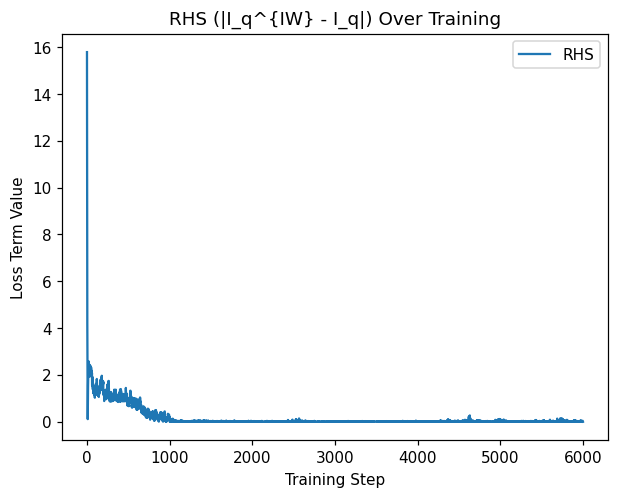

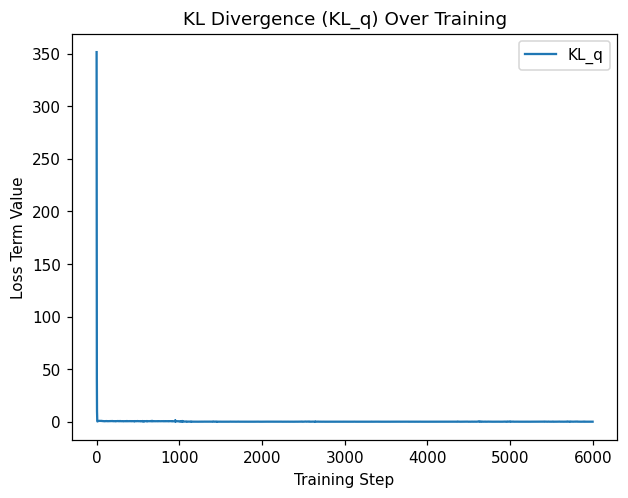

After adv mean tensor([-1.2498, -1.1236]) var tensor([372.7586, 407.6563])
After clean mean tensor([-1.3363, -1.3356]) var tensor([397.0743, 399.7568])


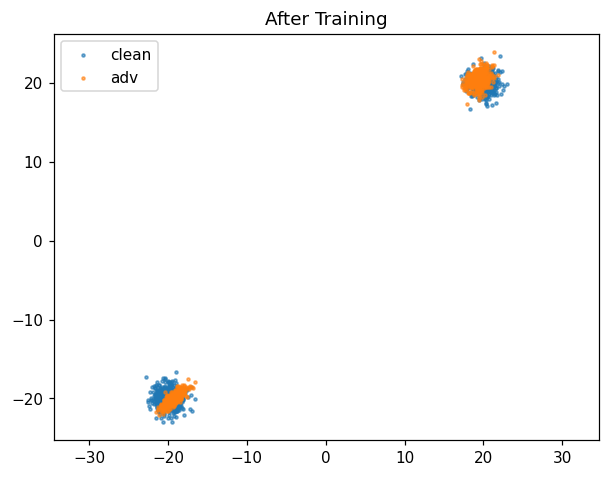

In [64]:
# 🚀 RHS‑only loss – track w(t) & distribution stats with intermediate plots
# clean p(x,y): y~N(0,I), x=y+ε (σ_c=0.1)
# adv   q(x,y): x=y+ε+Δ  (Δ=[3,-2])
# L(θ)= |I_q^{IW}-I_q| + KL_q   where KL_q is approximated by ((w_q-1)**2).mean()
# Critic–Encoder strict alternating updates; plot stats at 0%,25%,50%,75%,100% of training
#──────────────────────────────────────────────────────────
import torch, torch.nn as nn, torch.nn.functional as F, matplotlib.pyplot as plt, random
random.seed(0); torch.manual_seed(0)

σ_c = 0.1
Δ = torch.tensor([3.0, -2.0])

# ---------- data ----------
# ► clean: 2‑component Gaussian mixture + noise
# NOTE: centers and mix_probs have been updated as per your request.
# mix_probs was corrected to [0.5, 0.5] to be a valid probability distribution.
centers = torch.tensor([[-20.0, -20.0], [20.0, 20.0]])
mix_probs = torch.tensor([0.5, 0.5])

def sample_clean(bs: int):
    comp = torch.multinomial(mix_probs, bs, replacement=True)
    y = centers[comp] + torch.randn(bs,2)
    x = y + torch.randn_like(y)*σ_c
    return x, y

def sample_adv(bs: int):
    comp = torch.multinomial(mix_probs, bs, replacement=True)
    y = centers[comp] + torch.randn(bs,2)
    x = y + torch.randn_like(y)*σ_c + Δ
    return x, y

# ---------- models ----------
class Encoder(nn.Module):
    def __init__(self,hid=64): super().__init__(); self.net=nn.Sequential(nn.Linear(2,hid),nn.ReLU(),nn.Linear(hid,2))
    def forward(self,x): return self.net(x)
class Critic(nn.Module):
    def __init__(self): super().__init__(); self.net=nn.Sequential(nn.Linear(4,64),nn.ReLU(),nn.Linear(64,1))
    def forward(self,z,y): return self.net(torch.cat([z,y],dim=-1)).squeeze(-1)
φ, Dψ = Encoder(), Critic()
opt_φ, opt_ψ = torch.optim.Adam(φ.parameters(),1e-3), torch.optim.Adam(Dψ.parameters(),1e-3)
bce = nn.BCEWithLogitsLoss()

def IW_cos(z,y): t=F.cosine_similarity(z,y,dim=-1); return t.mean()-torch.log(torch.exp(t).mean())

def scatter(zc, za, title):
    plt.figure(dpi=110)
    plt.scatter(zc[:,0],zc[:,1],s=4,alpha=.6,label='clean')
    plt.scatter(za[:,0],za[:,1],s=4,alpha=.6,label='adv')
    plt.title(title); plt.axis('equal'); plt.legend(); plt.show()

# ---------- BEFORE stats ----------
with torch.no_grad():
    # plot clean cluster
    xc_clean, yc_clean = sample_clean(3000)
    zc_b = yc_clean  # clean embedding as ground-truth y
    # plot initial adv cluster
    xb_adv, yb_adv = sample_adv(300)
    za_b = φ(xb_adv)
print("Before adv mean", za_b.mean(0), "var", za_b.var(0))
print("Before clean mean", zc_b.mean(0), "var", zc_b.var(0))
scatter(zc_b, za_b, 'Before Training')

# ---------- training ----------
# Add logs for RHS (gap) and KL
w_log=[]; pprob_log=[]; iw_log=[]; iq_log=[]; gap_log=[]; kl_log=[]
steps, batch = 6000, 256
plot_steps = {0, steps//4, steps//2, 3*steps//4, steps}
for step in range(1, steps+1):
    # critic step
    x_p,y_p = sample_clean(batch)
    x_q,y_q = sample_adv(batch)
    z_p = y_p
    with torch.no_grad(): z_q_det = φ(x_q)
    opt_ψ.zero_grad()
    loss_ψ = bce(Dψ(z_p,y_p), torch.ones(batch)) + \
             bce(Dψ(z_q_det,y_q), torch.zeros(batch))
    loss_ψ.backward(); opt_ψ.step()

    # encoder step
    for p in Dψ.parameters(): p.requires_grad=False
    z_q = φ(x_q)
    logits_q = Dψ(z_q, y_q)
    p_prob = torch.sigmoid(logits_q)
    w_q = p_prob/(1-p_prob+1e-8)
    KL_q = ((w_q-1)**2).mean() # Approximation of KL
    idx = torch.randperm(batch)
    t_q = F.cosine_similarity(z_q, y_q, dim=-1)
    t_qp = F.cosine_similarity(z_q, y_q[idx], dim=-1)
    # weighted/unweighted MI per pseudo-algorithm
    Iq_IW = (w_q * t_q).mean() - torch.log((w_q * torch.exp(t_qp)).mean())
    Iq    = t_q.mean() - torch.log(torch.exp(t_qp).mean())
    gap = Iq_IW - Iq
    
    # Using the original loss function as requested
    loss_φ = torch.abs(gap) + KL_q
    opt_φ.zero_grad(); loss_φ.backward(); opt_φ.step()
    for p in Dψ.parameters(): p.requires_grad=True

    # logging
    w_log.append(w_q.mean().item())
    iw_log.append(Iq_IW.item())
    iq_log.append(Iq.item())
    pprob_log.append(p_prob.mean().item())
    # Log RHS and D_KL values
    gap_log.append(torch.abs(gap).item())
    kl_log.append(KL_q.item())
    
    if step in plot_steps:
        with torch.no_grad():
            xt, yt = sample_adv(500)
            zc = yt; za = φ(xt)
        scatter(zc, za, f'Training {step}/{steps}')
        # histogram of w_q for this batch
        plt.figure(dpi=110)
        hist_data = w_q.detach().cpu().numpy()
        plt.hist(hist_data, bins=30, alpha=0.7)
        plt.title(f'w_q Histogram at step {step}/{steps}')
        plt.xlabel('w_q'); plt.ylabel('Frequency'); plt.show()
    if step % 1000 == 0:
        # Corrected the print statement
        print(f"[{step}] gap={gap:.4f}, Iq_IW={Iq_IW:+.4f}, Iq={Iq:+.4f}, KL={KL_q:.3f}, w̄={w_q.mean():.3f}")


# ---------- AFTER trajectory plots ----------
# Plot mean w_q over training
plt.figure(dpi=110)
plt.plot(w_log)
plt.xlabel('Training Step')
plt.ylabel('E_q[w]')
plt.title('Mean w_q Over Training')
plt.show()

# Plot discriminator output probability p_prob
plt.figure(dpi=110)
plt.plot(pprob_log)
plt.xlabel('Training Step')
plt.ylabel('E_q[Dψ(z_q,y_q)]')
plt.title('Mean Discriminator Output Over Training')
plt.show()

# Plot MI metrics separately
plt.figure(dpi=110)
plt.plot(iq_log, label='I_q')
plt.legend()
plt.xlabel('Training Step')
plt.ylabel('Estimate')
plt.title('I_q Over Training')
plt.show()

plt.figure(dpi=110)
plt.plot(iw_log, label='I_q^{IW}')
plt.legend()
plt.xlabel('Training Step')
plt.ylabel('Estimate')
plt.title('I_q^{IW} Over Training')
plt.show()

# ========================== NEW PLOTS ==========================
# Plot RHS |I_q^{IW} - I_q|
plt.figure(dpi=110)
plt.plot(gap_log, label='RHS')
plt.legend()
plt.xlabel('Training Step')
plt.ylabel('Loss Term Value')
plt.title('RHS (|I_q^{IW} - I_q|) Over Training')
plt.show()

# Plot KL Divergence
plt.figure(dpi=110)
plt.plot(kl_log, label='KL_q')
plt.legend()
plt.xlabel('Training Step')
plt.ylabel('Loss Term Value')
plt.title('KL Divergence (KL_q) Over Training')
plt.show()
# ===============================================================


# ---------- AFTER stats ----------
with torch.no_grad():
    xt,yt = sample_adv(1000)
    zc = yt; za = φ(xt)
print("After adv mean", za.mean(0), "var", za.var(0))
print("After clean mean", zc.mean(0), "var", zc.var(0))
scatter(zc, za, 'After Training')


Before adv mean tensor([-3.5704, -2.2800]) var tensor([21.0652, 20.4712])
Before clean mean tensor([-0.3914, -0.3826]) var tensor([400.7792, 401.1656])


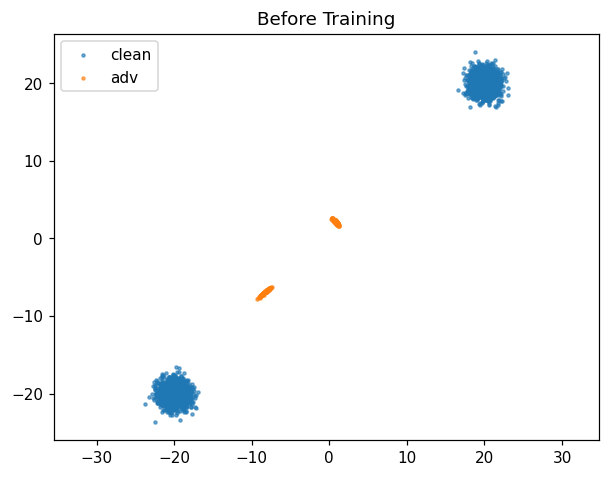

[1000] New_Loss(MSE)=0.1522, gap=0.0022, KL=0.010, w̄=1.049
[2000] New_Loss(MSE)=0.0388, gap=-0.0033, KL=0.006, w̄=1.001


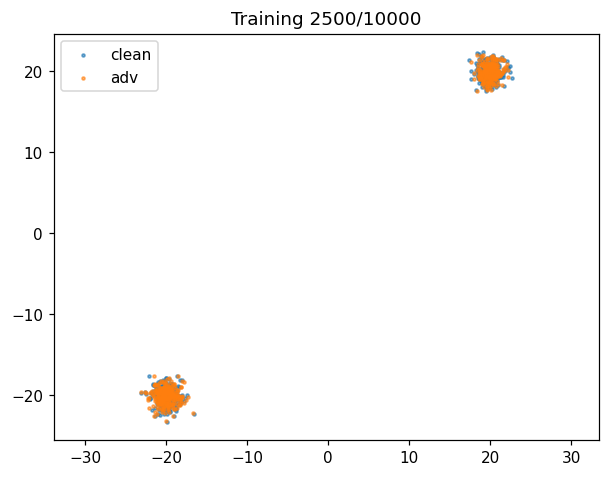

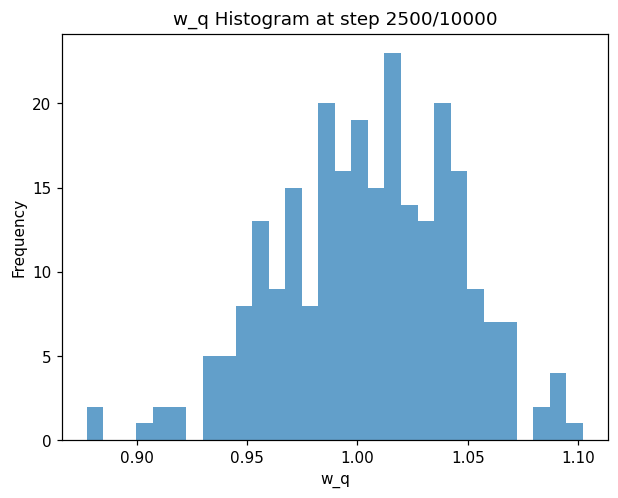

[3000] New_Loss(MSE)=0.0185, gap=-0.0003, KL=0.002, w̄=0.968
[4000] New_Loss(MSE)=0.0176, gap=-0.0015, KL=0.001, w̄=0.991


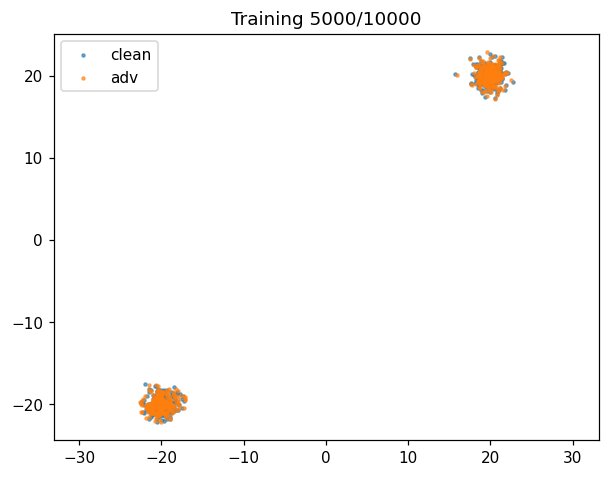

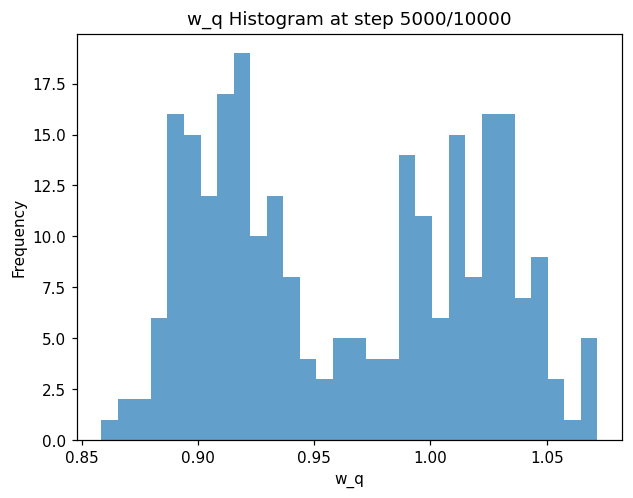

[5000] New_Loss(MSE)=0.0147, gap=-0.0018, KL=0.005, w̄=0.964
[6000] New_Loss(MSE)=0.0164, gap=-0.0014, KL=0.015, w̄=1.062
[7000] New_Loss(MSE)=0.0141, gap=0.0250, KL=0.048, w̄=0.998


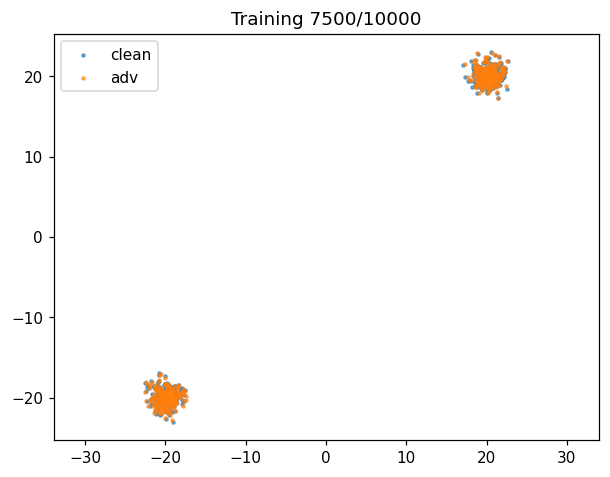

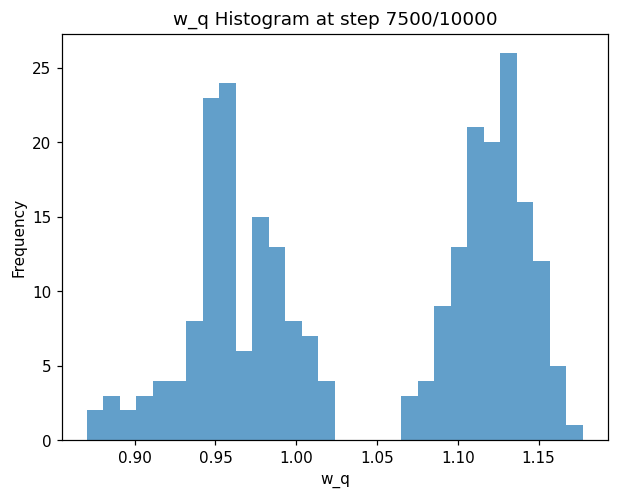

[8000] New_Loss(MSE)=0.0125, gap=0.0001, KL=0.001, w̄=1.018
[9000] New_Loss(MSE)=0.0133, gap=0.0176, KL=0.018, w̄=0.944


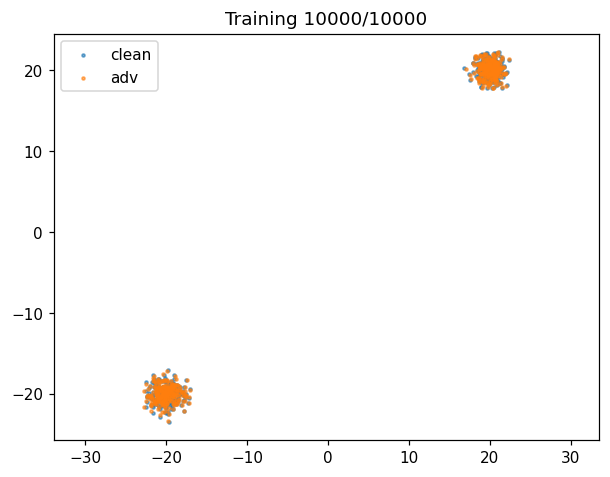

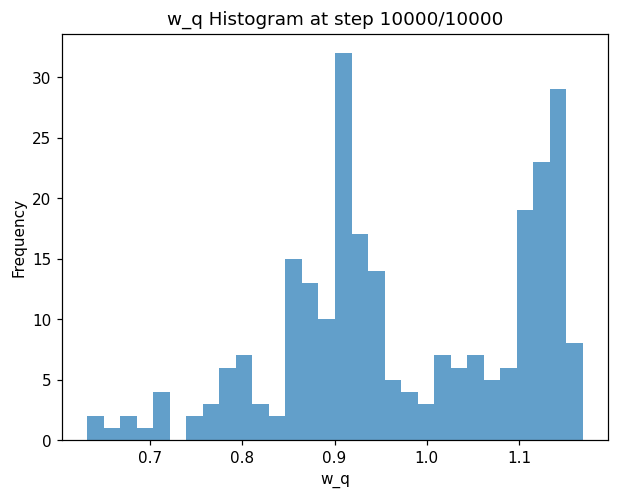

[10000] New_Loss(MSE)=0.0107, gap=-0.0056, KL=0.018, w̄=0.977


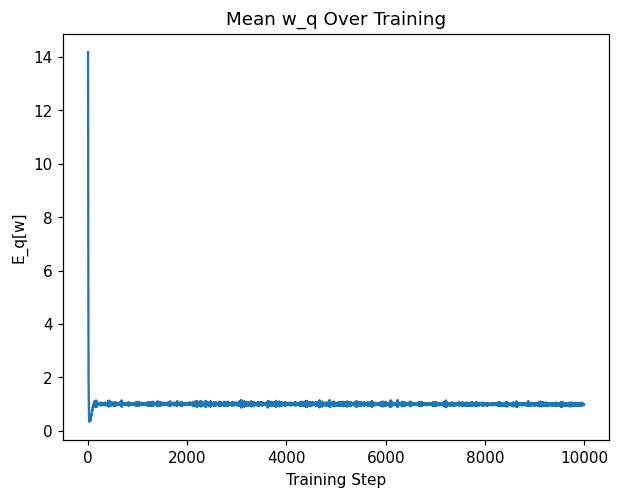

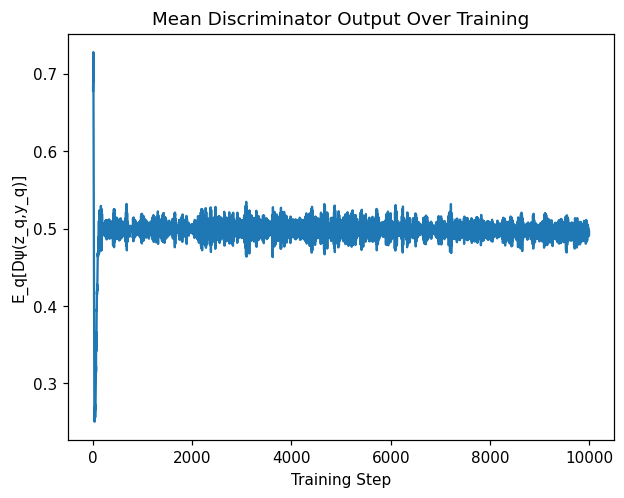

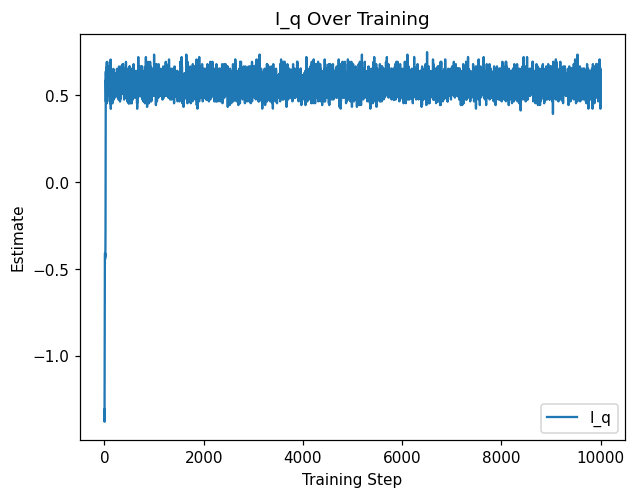

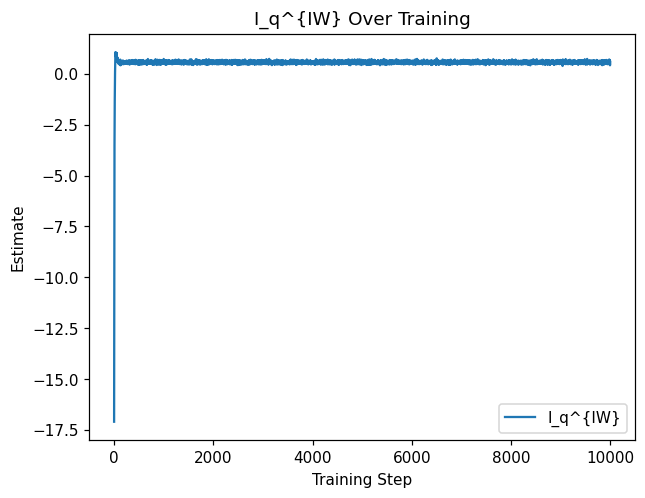

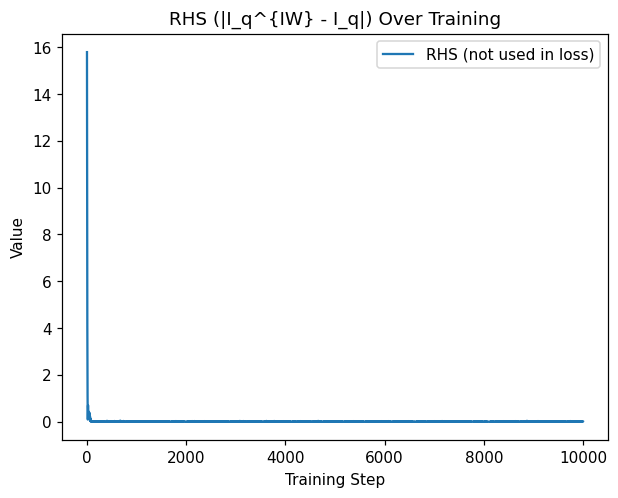

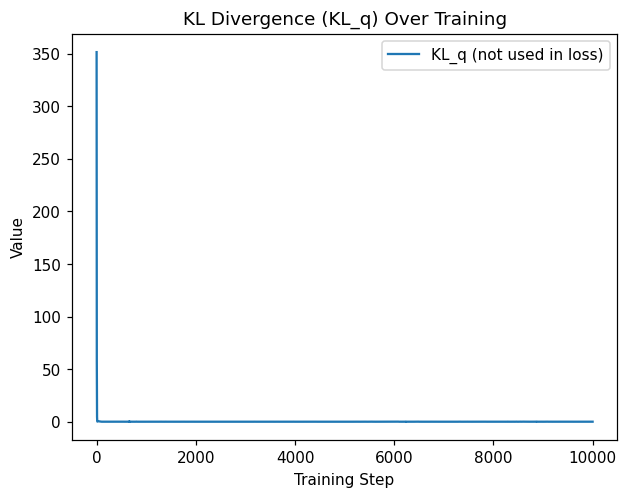

After adv mean tensor([1.1960, 1.2013]) var tensor([401.2706, 400.2673])
After clean mean tensor([1.2095, 1.2229]) var tensor([401.5725, 400.9424])


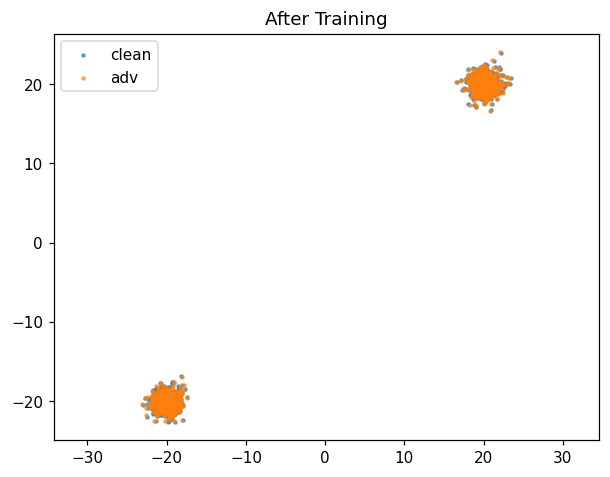

In [73]:
# 🚀 RHS‑only loss – track w(t) & distribution stats with intermediate plots
# clean p(x,y): y~N(0,I), x=y+ε (σ_c=0.1)
# adv   q(x,y): x=y+ε+Δ  (Δ=[3,-2])
# L(θ)= ||y_q - φ(x_q)||_2^2  (MSE Loss)
# Critic–Encoder strict alternating updates; plot stats at 0%,25%,50%,75%,100% of training
#──────────────────────────────────────────────────────────
import torch, torch.nn as nn, torch.nn.functional as F, matplotlib.pyplot as plt, random
random.seed(0); torch.manual_seed(0)

σ_c = 0.1
Δ = torch.tensor([3.0, -2.0])

# ---------- data ----------
# ► clean: 2‑component Gaussian mixture + noise
centers = torch.tensor([[-20.0, -20.0], [20.0, 20.0]])
mix_probs = torch.tensor([0.5, 0.5])

def sample_clean(bs: int):
    comp = torch.multinomial(mix_probs, bs, replacement=True)
    y = centers[comp] + torch.randn(bs,2)
    x = y + torch.randn_like(y)*σ_c
    return x, y

def sample_adv(bs: int):
    comp = torch.multinomial(mix_probs, bs, replacement=True)
    y = centers[comp] + torch.randn(bs,2)
    x = y + torch.randn_like(y)*σ_c + Δ
    return x, y

# ---------- models ----------
class Encoder(nn.Module):
    def __init__(self,hid=64): super().__init__(); self.net=nn.Sequential(nn.Linear(2,hid),nn.ReLU(),nn.Linear(hid,2))
    def forward(self,x): return self.net(x)
class Critic(nn.Module):
    def __init__(self): super().__init__(); self.net=nn.Sequential(nn.Linear(4,64),nn.ReLU(),nn.Linear(64,1))
    def forward(self,z,y): return self.net(torch.cat([z,y],dim=-1)).squeeze(-1)
φ, Dψ = Encoder(), Critic()
opt_φ, opt_ψ = torch.optim.Adam(φ.parameters(),1e-3), torch.optim.Adam(Dψ.parameters(),1e-3)
bce = nn.BCEWithLogitsLoss()

def IW_cos(z,y): t=F.cosine_similarity(z,y,dim=-1); return t.mean()-torch.log(torch.exp(t).mean())

def scatter(zc, za, title):
    plt.figure(dpi=110)
    plt.scatter(zc[:,0],zc[:,1],s=4,alpha=.6,label='clean')
    plt.scatter(za[:,0],za[:,1],s=4,alpha=.6,label='adv')
    plt.title(title); plt.axis('equal'); plt.legend(); plt.show()

# ---------- BEFORE stats ----------
with torch.no_grad():
    # plot clean cluster
    xc_clean, yc_clean = sample_clean(3000)
    zc_b = yc_clean  # clean embedding as ground-truth y
    # plot initial adv cluster
    xb_adv, yb_adv = sample_adv(300)
    za_b = φ(xb_adv)
print("Before adv mean", za_b.mean(0), "var", za_b.var(0))
print("Before clean mean", zc_b.mean(0), "var", zc_b.var(0))
scatter(zc_b, za_b, 'Before Training')

# ---------- training ----------
# Add logs for RHS (gap) and KL
w_log=[]; pprob_log=[]; iw_log=[]; iq_log=[]; gap_log=[]; kl_log=[]
steps, batch = 10000, 256
plot_steps = {0, steps//4, steps//2, 3*steps//4, steps}
for step in range(1, steps+1):
    # critic step
    x_p,y_p = sample_clean(batch)
    x_q,y_q = sample_adv(batch)
    z_p = y_p
    with torch.no_grad(): z_q_det = φ(x_q)
    opt_ψ.zero_grad()
    loss_ψ = bce(Dψ(z_p,y_p), torch.ones(batch)) + \
             bce(Dψ(z_q_det,y_q), torch.zeros(batch))
    loss_ψ.backward(); opt_ψ.step()

    # encoder step
    for p in Dψ.parameters(): p.requires_grad=False
    z_q = φ(x_q)

    # ========================== LOSS MODIFICATION ==========================
    # 새로운 손실: adversarial 임베딩 z_q와 해당하는 clean 잠재변수 y_q 사이의 L2 norm 제곱
    loss_φ = F.mse_loss(z_q, y_q)

    # 역전파 및 파라미터 업데이트는 새로운 손실(loss_φ)을 사용
    opt_φ.zero_grad(); loss_φ.backward(); opt_φ.step()
    # =======================================================================
    
    # 기존 로깅을 위해 이전 메트릭들을 계산 (그래디언트에는 영향을 주지 않음)
    with torch.no_grad():
        logits_q = Dψ(z_q, y_q)
        p_prob = torch.sigmoid(logits_q)
        w_q = p_prob/(1-p_prob+1e-8)
        KL_q = ((w_q-1)**2).mean() # Approximation of KL
        idx = torch.randperm(batch)
        t_q = F.cosine_similarity(z_q, y_q, dim=-1)
        t_qp = F.cosine_similarity(z_q, y_q[idx], dim=-1)
        Iq_IW = (w_q * t_q).mean() - torch.log((w_q * torch.exp(t_qp)).mean())
        Iq    = t_q.mean() - torch.log(torch.exp(t_qp).mean())
        gap = Iq_IW - Iq

    for p in Dψ.parameters(): p.requires_grad=True

    # logging
    w_log.append(w_q.mean().item())
    iw_log.append(Iq_IW.item())
    iq_log.append(Iq.item())
    pprob_log.append(p_prob.mean().item())
    # Log RHS and D_KL values
    gap_log.append(torch.abs(gap).item())
    kl_log.append(KL_q.item())
    
    if step in plot_steps:
        with torch.no_grad():
            xt, yt = sample_adv(500)
            zc = yt; za = φ(xt)
        scatter(zc, za, f'Training {step}/{steps}')
        # histogram of w_q for this batch
        plt.figure(dpi=110)
        hist_data = w_q.detach().cpu().numpy()
        plt.hist(hist_data, bins=30, alpha=0.7)
        plt.title(f'w_q Histogram at step {step}/{steps}')
        plt.xlabel('w_q'); plt.ylabel('Frequency'); plt.show()
    if step % 1000 == 0:
        # 출력 메시지에 새로운 loss 값을 추가하여 확인
        print(f"[{step}] New_Loss(MSE)={loss_φ.item():.4f}, gap={gap:.4f}, KL={KL_q:.3f}, w̄={w_q.mean():.3f}")


# ---------- AFTER trajectory plots ----------
# Plot mean w_q over training
plt.figure(dpi=110)
plt.plot(w_log)
plt.xlabel('Training Step')
plt.ylabel('E_q[w]')
plt.title('Mean w_q Over Training')
plt.show()

# Plot discriminator output probability p_prob
plt.figure(dpi=110)
plt.plot(pprob_log)
plt.xlabel('Training Step')
plt.ylabel('E_q[Dψ(z_q,y_q)]')
plt.title('Mean Discriminator Output Over Training')
plt.show()

# Plot MI metrics separately
plt.figure(dpi=110)
plt.plot(iq_log, label='I_q')
plt.legend()
plt.xlabel('Training Step')
plt.ylabel('Estimate')
plt.title('I_q Over Training')
plt.show()

plt.figure(dpi=110)
plt.plot(iw_log, label='I_q^{IW}')
plt.legend()
plt.xlabel('Training Step')
plt.ylabel('Estimate')
plt.title('I_q^{IW} Over Training')
plt.show()

# ========================== PLOTS for original loss terms ==========================
# Plot RHS |I_q^{IW} - I_q|
plt.figure(dpi=110)
plt.plot(gap_log, label='RHS (not used in loss)')
plt.legend()
plt.xlabel('Training Step')
plt.ylabel('Value')
plt.title('RHS (|I_q^{IW} - I_q|) Over Training')
plt.show()

# Plot KL Divergence
plt.figure(dpi=110)
plt.plot(kl_log, label='KL_q (not used in loss)')
plt.legend()
plt.xlabel('Training Step')
plt.ylabel('Value')
plt.title('KL Divergence (KL_q) Over Training')
plt.show()
# ===============================================================


# ---------- AFTER stats ----------
with torch.no_grad():
    xt,yt = sample_adv(1000)
    zc = yt; za = φ(xt)
print("After adv mean", za.mean(0), "var", za.var(0))
print("After clean mean", zc.mean(0), "var", zc.var(0))
scatter(zc, za, 'After Training')


Sampled mix_probs: tensor([0.3761, 0.0593, 0.0151, 0.0069, 0.0307, 0.0507, 0.0239, 0.2648, 0.0395,
        0.1331])


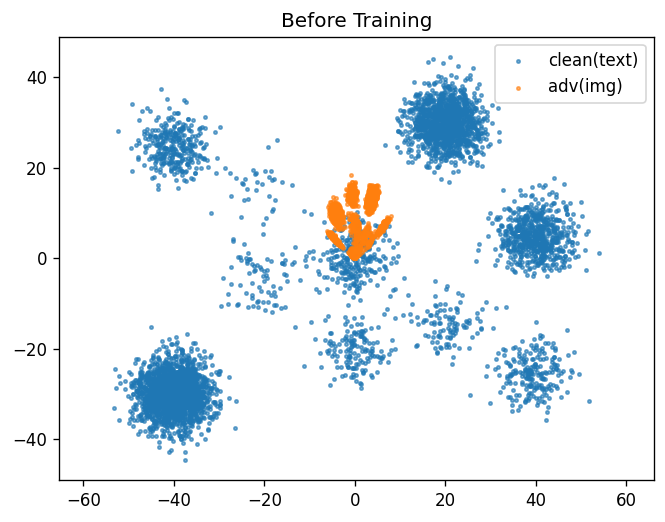

[1000] loss=1.0225, gap=0.5114, KL=0.5111, w̄=0.352
[2000] loss=0.3154, gap=0.0462, KL=0.2693, w̄=0.820
[3000] loss=0.4353, gap=0.1298, KL=0.3055, w̄=0.696
[4000] loss=0.3882, gap=0.1291, KL=0.2591, w̄=0.636
[5000] loss=0.3402, gap=0.0402, KL=0.3001, w̄=0.753
[6000] loss=0.3509, gap=0.0798, KL=0.2711, w̄=0.670
[7000] loss=0.4815, gap=0.0007, KL=0.4808, w̄=1.006


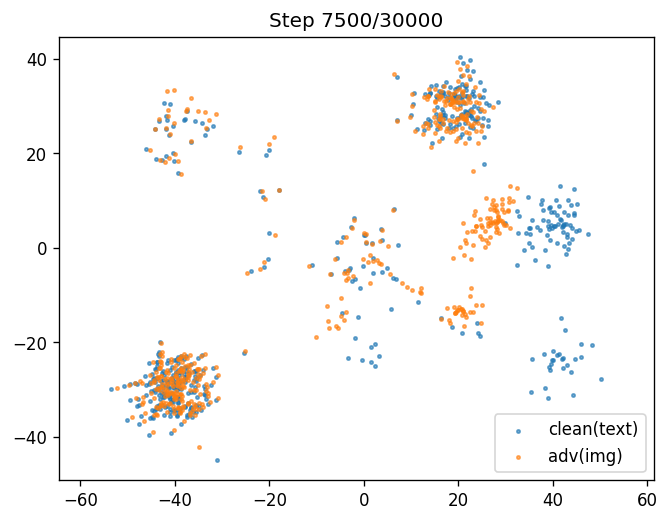

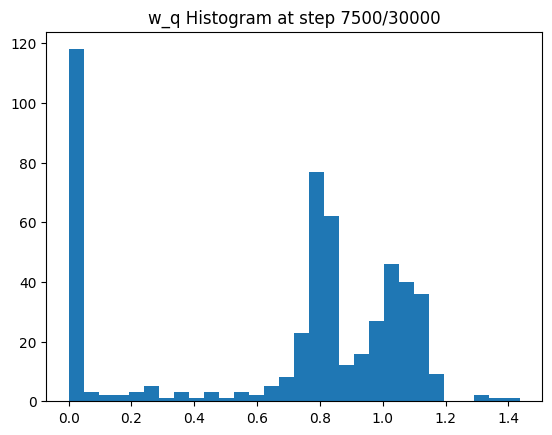

[8000] loss=0.2134, gap=-0.0229, KL=0.2363, w̄=0.781
[9000] loss=0.2887, gap=0.0322, KL=0.2565, w̄=0.788
[10000] loss=0.1962, gap=0.0412, KL=0.1551, w̄=0.733
[11000] loss=0.0983, gap=-0.0098, KL=0.1081, w̄=0.826
[12000] loss=0.8681, gap=0.3007, KL=0.5674, w̄=0.450
[13000] loss=0.8274, gap=0.2252, KL=0.6022, w̄=0.478
[14000] loss=0.5301, gap=0.0960, KL=0.4341, w̄=0.593


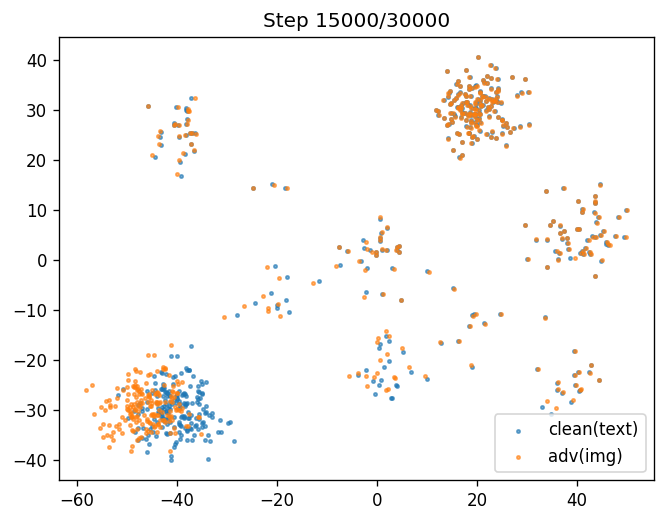

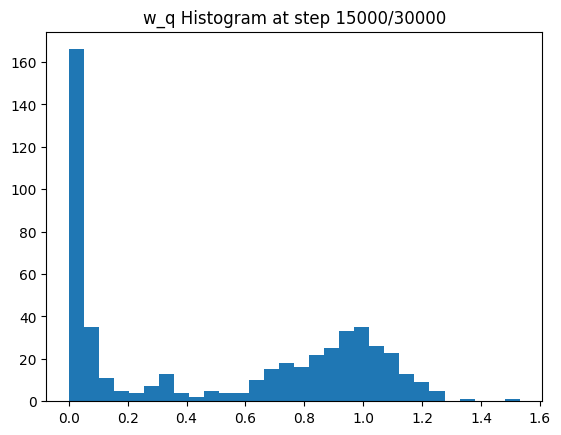

[15000] loss=0.6844, gap=0.2452, KL=0.4393, w̄=0.511
[16000] loss=0.3159, gap=0.0324, KL=0.2834, w̄=0.891
[17000] loss=0.2666, gap=-0.0003, KL=0.2669, w̄=0.822
[18000] loss=0.2385, gap=-0.0138, KL=0.2524, w̄=0.793
[19000] loss=0.3952, gap=-0.0283, KL=0.4234, w̄=0.731
[20000] loss=1.1160, gap=0.3798, KL=0.7362, w̄=0.371
[21000] loss=0.4692, gap=0.0335, KL=0.4357, w̄=0.705
[22000] loss=0.4280, gap=-0.0332, KL=0.4612, w̄=0.787


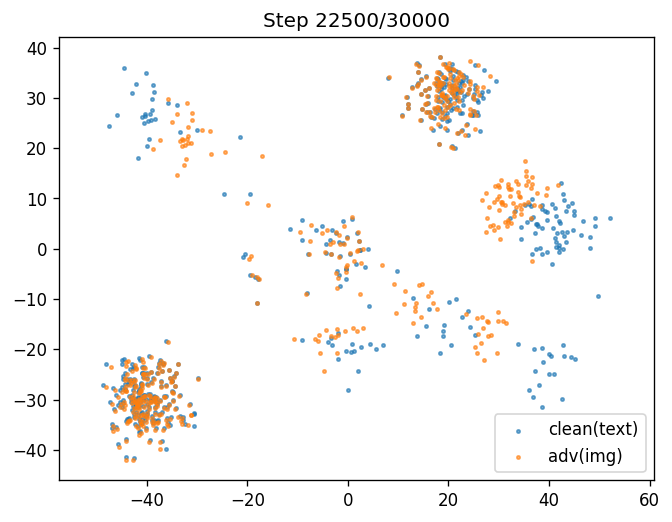

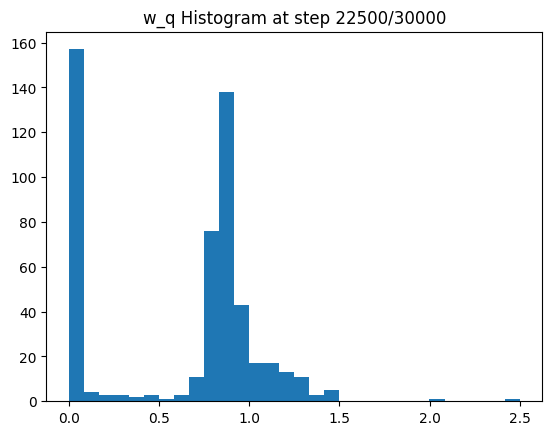

[23000] loss=0.3666, gap=0.0194, KL=0.3471, w̄=0.719
[24000] loss=0.4196, gap=0.0563, KL=0.3634, w̄=0.646
[25000] loss=0.4447, gap=0.0295, KL=0.4151, w̄=0.785
[26000] loss=0.4747, gap=-0.0004, KL=0.4750, w̄=0.875
[27000] loss=0.5104, gap=-0.0492, KL=0.5596, w̄=0.975
[28000] loss=0.3876, gap=0.0378, KL=0.3497, w̄=0.654
[29000] loss=0.4258, gap=0.0411, KL=0.3847, w̄=0.635


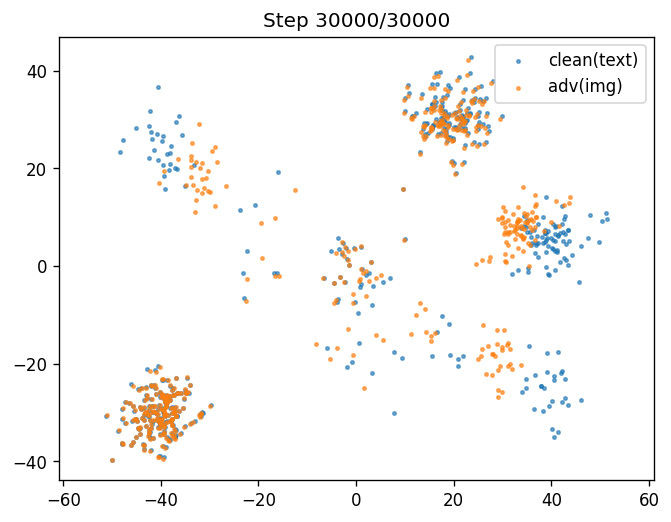

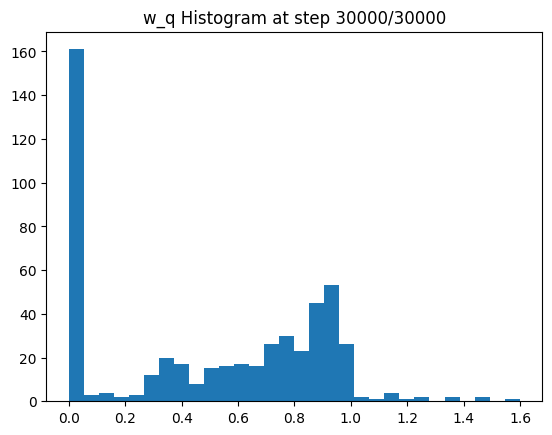

[30000] loss=0.5633, gap=0.1528, KL=0.4105, w̄=0.497
After training:


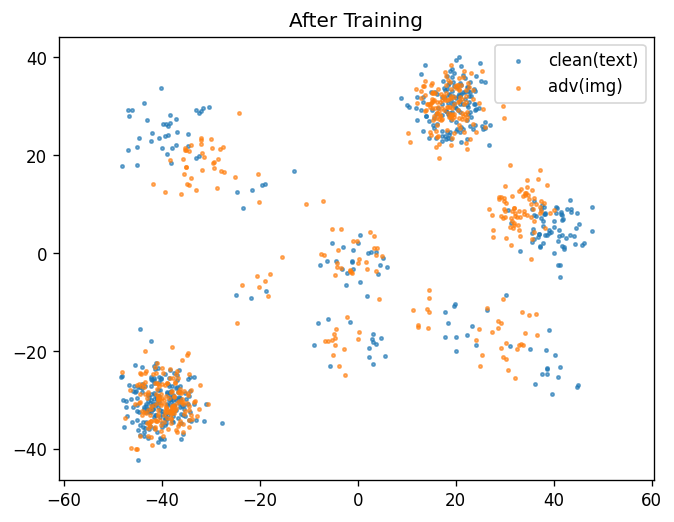

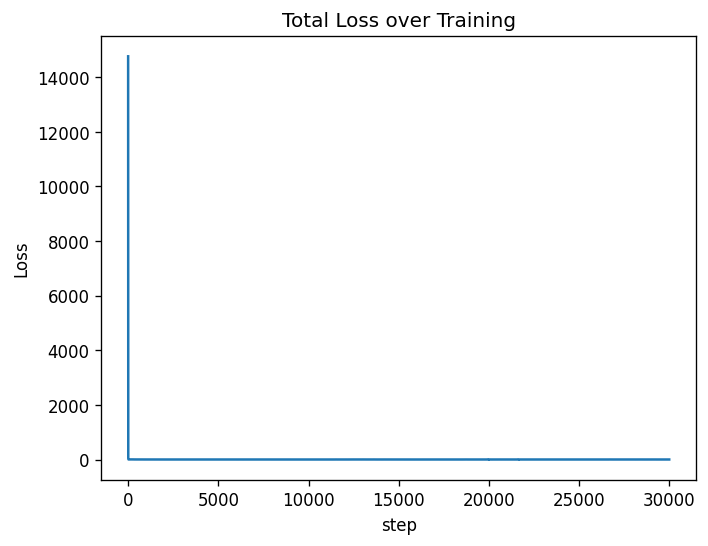

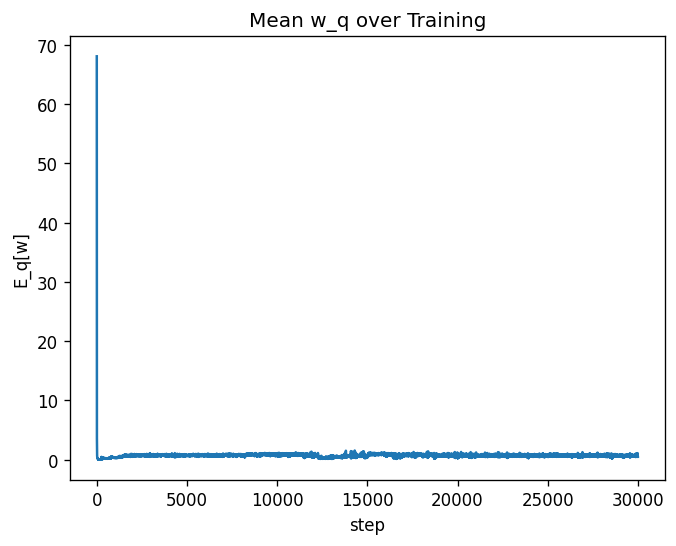

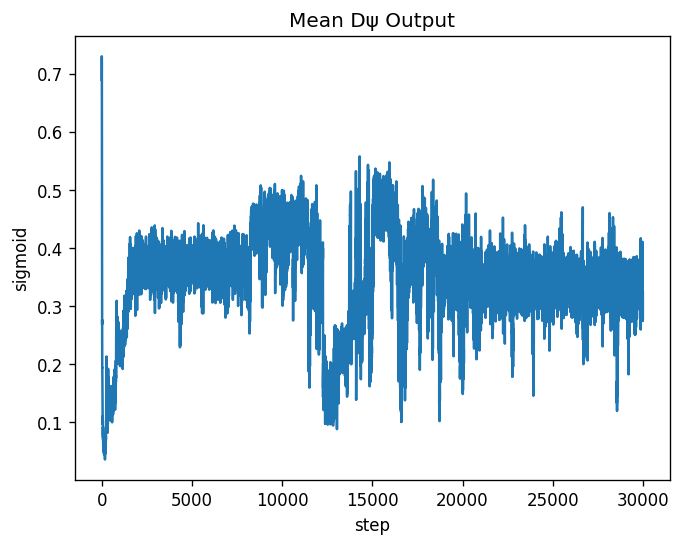

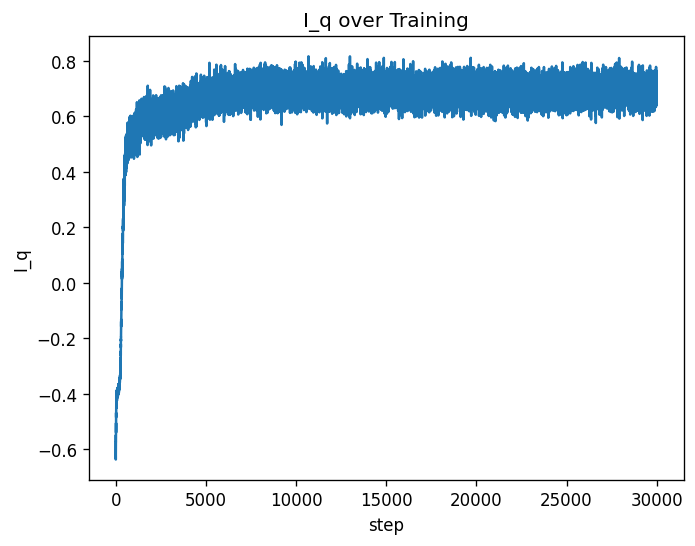

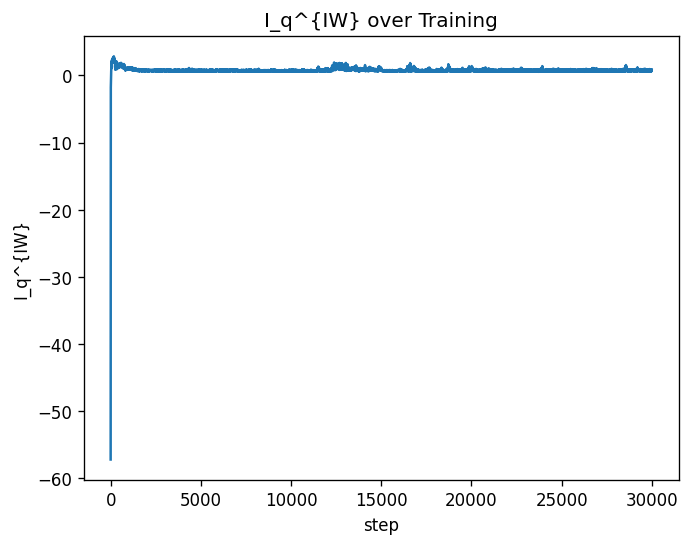

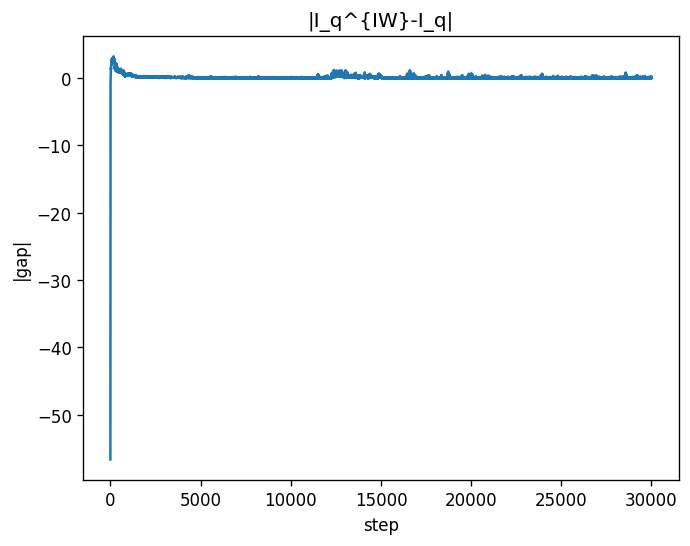

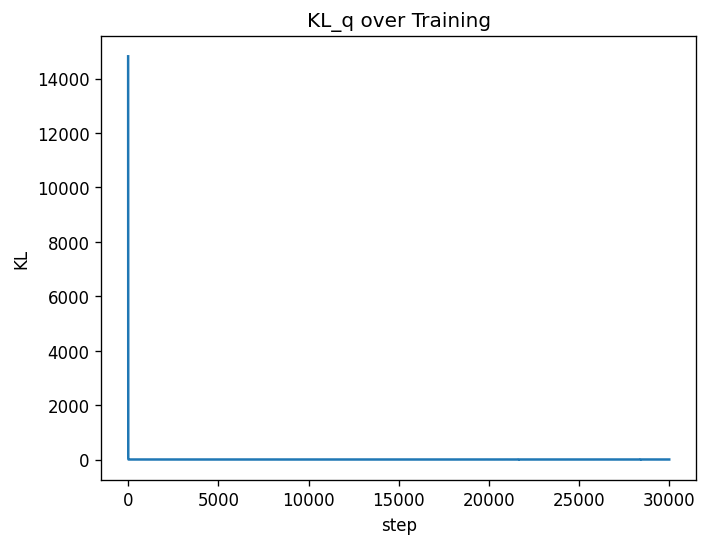

In [118]:
# 🚀 Toy Multi-Modal Alignment Demo without σ or Δ
# Align adversarial image embeddings φ(x_adv) to fixed text embeddings θ(y)
# using RHS-only loss: |Ĩ_q^{IW} - Ĩ_q| + KL_q, with PGD attack only

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torch.distributions.dirichlet import Dirichlet
# reproducibility
random.seed(0)
torch.manual_seed(0)

# ──────────── 1. Setup Modalities ────────────
# Clean text distribution: 2-component Gaussian mixture
centers = torch.tensor([
    [-40.0, -30.0], [-40.0, 25.0],
    [-20.0, -5.0], [-20.0, 15.0],
    [0.0, -20.0], [0.0, 0.0],
    [20.0, -15.0], [20.0, 30.0],
    [40.0, -25.0], [40.0, 5.0]
])
# Sample mix_probs from a Dirichlet distribution for imbalanced clusters
dirichlet_concentration = torch.ones(10) # Concentration parameter for 10 clusters
mix_probs_dist = Dirichlet(dirichlet_concentration)
mix_probs = mix_probs_dist.sample()
print(f"Sampled mix_probs: {mix_probs}")


# Text encoder θ: fixed identity mapping
class TextEnc(nn.Module):
    def forward(self, y): return y.clone()
θ = TextEnc()
θ.eval()

# Sample clean joint (x, y_emb)
# Adjusted sample_clean to include noise in y sampling for variation
σ_y = 4  # noise scale for text mixture

def sample_clean(bs: int):
    comp = torch.multinomial(mix_probs, bs, replacement=True)
    y = centers[comp] + torch.randn(bs,2) * σ_y  # add noise to y for spread
    x = y.clone()  # image embed = text embed
    return x, θ(y)

# PGD attack on φ(x) to create adversarial x_adv
def pgd_attack(x, y_emb, φ, eps=1, alpha=0.1, iters=25):
    x_adv = x.clone().detach()
    for _ in range(iters):
        x_adv.requires_grad_(True)
        z = φ(x_adv)
        # maximize cosine distance (minimize sim)
        loss = F.cosine_similarity(z, y_emb, dim=-1).mean()
        grad = torch.autograd.grad(loss, x_adv)[0]
        x_adv = x_adv + alpha * grad.sign()
        # project within L∞ ball around x
        x_adv = torch.max(torch.min(x_adv, x + eps), x - eps).detach()
    return x_adv

# ──────────── 2. Model Definitions ────────────
class ImgEnc(nn.Module):
    def __init__(self,hid=64):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(2,hid), nn.ReLU(), nn.Linear(hid,2))
    def forward(self, x): return self.net(x)
φ = ImgEnc()

class Critic(nn.Module):
    def __init__(self,hid=64):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(4, hid), nn.ReLU(), nn.Linear(hid,1))
    def forward(self, z_img, z_txt):
        return self.net(torch.cat([z_img, z_txt], dim=-1)).squeeze(-1)
Dψ = Critic()

# optimizers and loss
opt_φ = torch.optim.AdamW(φ.parameters(), lr=1e-3)
opt_ψ = torch.optim.AdamW(Dψ.parameters(), lr=1e-3)
bce = nn.BCEWithLogitsLoss()

def T_cos(z_img, z_txt): return F.cosine_similarity(z_img, z_txt, dim=-1)

def scatter(zc, za, title):
    plt.figure(dpi=120)
    plt.scatter(zc[:,0],zc[:,1],s=4,alpha=0.6,label='clean(text)')
    plt.scatter(za[:,0],za[:,1],s=4,alpha=0.6,label='adv(img)')
    plt.title(title); plt.legend(); plt.axis('equal'); plt.show()

# ──────────── 3. Before Training ────────────
x0,y0 = sample_clean(5000)
scatter(y0, φ(x0).detach(), 'Before Training')

# ──────────── 4. Training Loop ────────────
w_log, p_log, iw_log, iq_log, gap_log, kl_log, loss_log = ([] for _ in range(7))
steps, bs = 30000, 512
plot_steps = {0, steps//4, steps//2, 3*steps//4, steps}

for step in range(1, steps+1):
    # critic update (φ frozen)
    x_p, y_p = sample_clean(bs)
    x_c, y_c = sample_clean(bs)
    x_adv = pgd_attack(x_c, y_c, φ)
    z_p = y_p
    with torch.no_grad(): z_q_det = φ(x_adv)
    opt_ψ.zero_grad()
    loss_ψ = bce(Dψ(z_p, y_p), torch.ones(bs)) + bce(Dψ(z_q_det, y_c), torch.zeros(bs))
    loss_ψ.backward(); opt_ψ.step()

    # encoder update (ψ frozen)
    for p in Dψ.parameters(): p.requires_grad=False
    z_q = φ(x_adv)
    logits = Dψ(z_q, y_c)
    p_prob = torch.sigmoid(logits)
    w_q = p_prob / (1 - p_prob + 1e-8)
    #KL_q = (w_q * torch.log(w_q + 1e-8)).mean()
    KL_q = ((w_q - 1) ** 2).mean()  # Approximation of KL
    idx = torch.randperm(bs)
    y_sh = y_c[idx]
    t = T_cos(z_q, y_c)
    t_sh = T_cos(z_q, y_sh)
    Iq_IW = (w_q * t).mean() - torch.log((w_q * torch.exp(t_sh)).mean())
    Iq    = t.mean() - torch.log(torch.exp(t_sh).mean())
    gap   = Iq_IW - Iq
    loss_φ = gap + KL_q
    opt_φ.zero_grad(); loss_φ.backward(); opt_φ.step()
    for p in Dψ.parameters(): p.requires_grad=True

    # log
    w_log.append(w_q.mean().item()); p_log.append(p_prob.mean().item())
    iw_log.append(Iq_IW.item()); iq_log.append(Iq.item())
    gap_log.append(gap.item()); kl_log.append(KL_q.item()); loss_log.append(loss_φ.item())

    # intermediate plots
    if step in plot_steps:
        x_s, y_s = sample_clean(500)
        x_adv_s = pgd_attack(x_s, y_s, φ)
        scatter(y_s, φ(x_adv_s).detach(), f'Step {step}/{steps}')
        plt.hist(w_q.detach().cpu().numpy(), bins=30)
        plt.title(f'w_q Histogram at step {step}/{steps}'); plt.show()
    if step % 1000 == 0:
        print(f"[{step}] loss={loss_φ:.4f}, gap={gap:.4f}, KL={KL_q:.4f}, w̄={w_q.mean():.3f}")

# ──────────── 5. After Training & Metrics ────────────
print('After training:')
scatter(*sample_clean(500)[1:], φ(sample_clean(500)[0]).detach(), 'After Training')

def plot(data,title,yl):
    plt.figure(dpi=120); plt.plot(data); plt.title(title); plt.ylabel(yl); plt.xlabel('step'); plt.show()

plot(loss_log,'Total Loss over Training','Loss')
plot(w_log,'Mean w_q over Training','E_q[w]')
plot(p_log,'Mean Dψ Output','sigmoid')
plot(iq_log,'I_q over Training','I_q')
plot(iw_log,'I_q^{IW} over Training','I_q^{IW}')
plot(gap_log,'|I_q^{IW}-I_q|','|gap|')
plot(kl_log,'KL_q over Training','KL')


Sampled mix_probs: tensor([0.3761, 0.0593, 0.0151, 0.0069, 0.0307, 0.0507, 0.0239, 0.2648, 0.0395,
        0.1331])


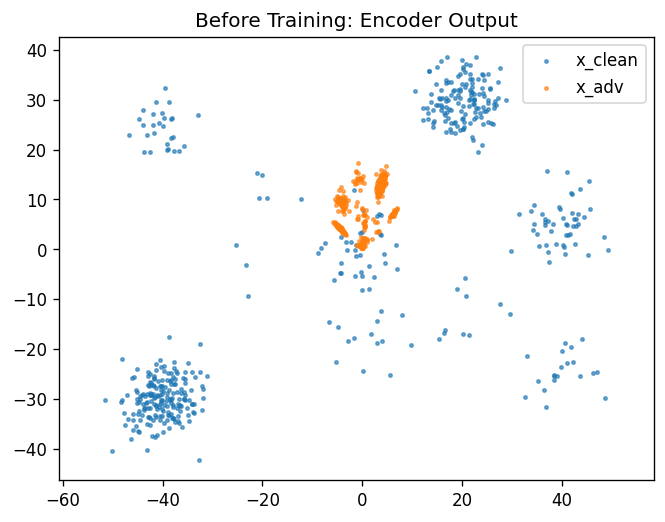

[1000] MSE Loss=0.0000


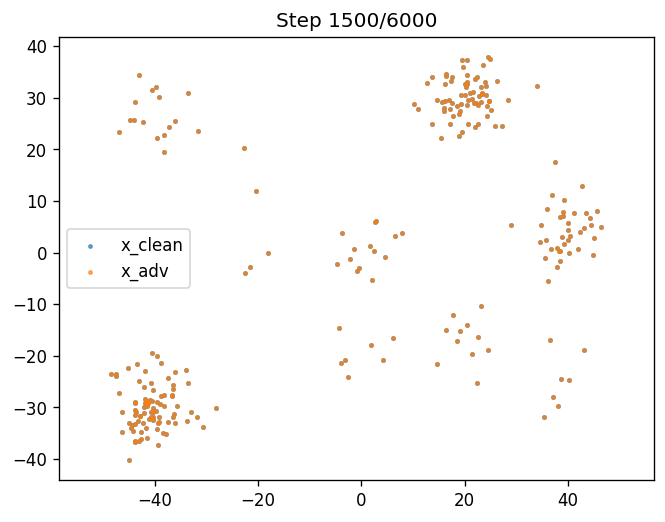

[2000] MSE Loss=0.0000


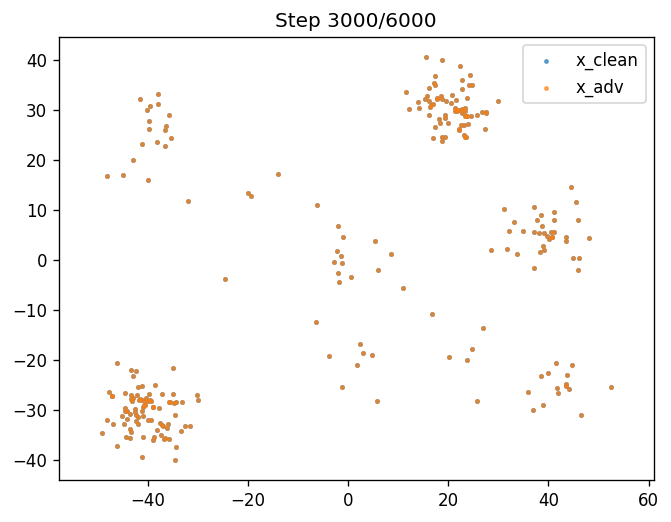

[3000] MSE Loss=0.0000
[4000] MSE Loss=0.0000


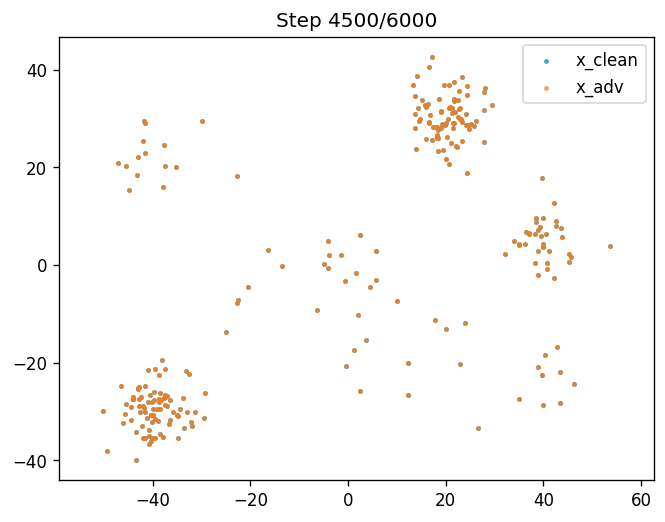

[5000] MSE Loss=0.0000


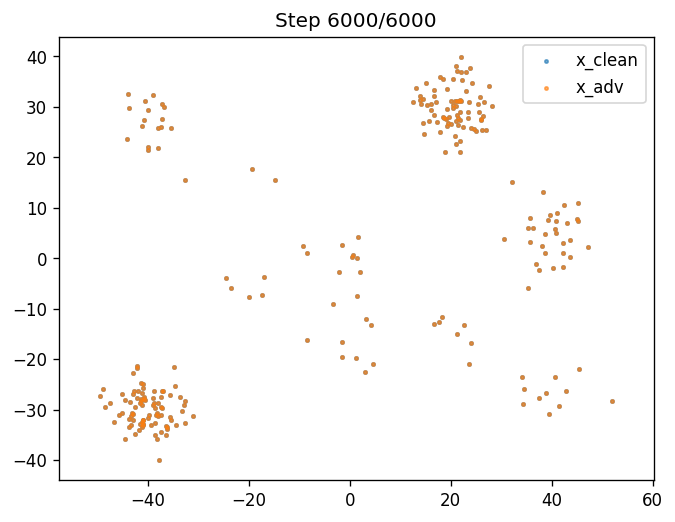

[6000] MSE Loss=0.0000
After training:


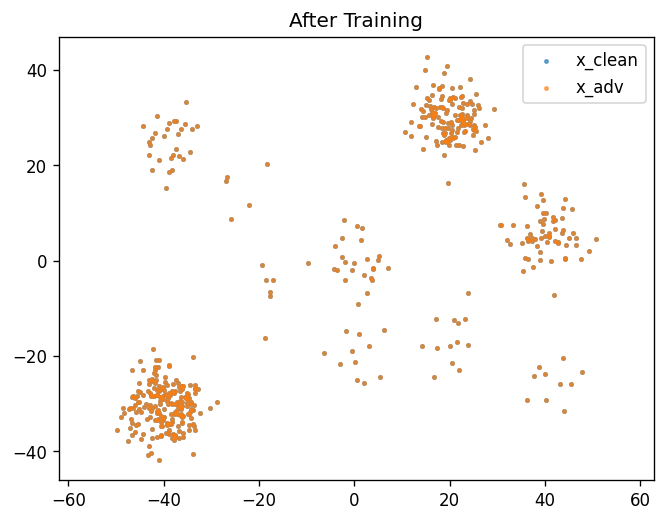

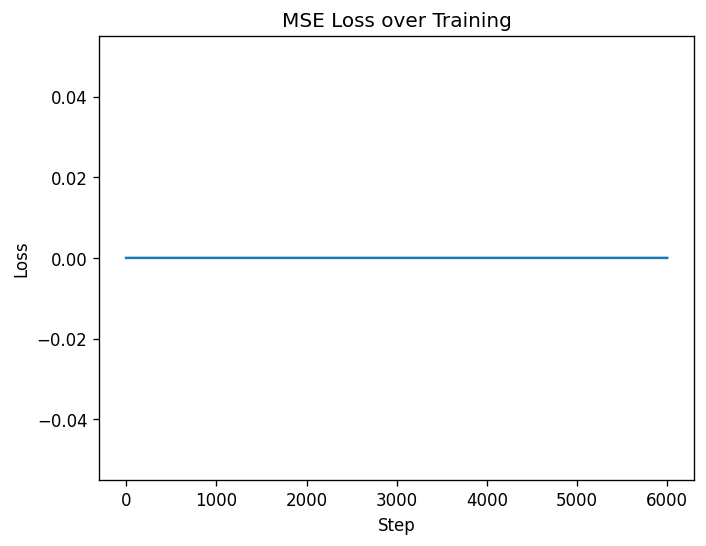

In [116]:
# 🚀 Toy Multi-Modal Alignment Demo (Proper MSE on Inputs)
# Goal: Align adversarial images x_adv to clean images x_clean via encoder φ,
# using pure L2 MSE loss between x_adv and x_clean.

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torch.distributions.dirichlet import Dirichlet


random.seed(0)
torch.manual_seed(0)


centers = torch.tensor([
    [-40.0, -30.0], [-40.0, 25.0],
    [-20.0, -5.0], [-20.0, 15.0],
    [0.0, -20.0], [0.0, 0.0],
    [20.0, -15.0], [20.0, 30.0],
    [40.0, -25.0], [40.0, 5.0]
])

σ_y =4 
# Sample mix_probs from a Dirichlet distribution for imbalanced clusters
dirichlet_concentration = torch.ones(10) # Concentration parameter for 10 clusters
mix_probs_dist = Dirichlet(dirichlet_concentration)
mix_probs = mix_probs_dist.sample()
print(f"Sampled mix_probs: {mix_probs}")
# Text encoder θ: fixed identity mapping
class TextEnc(nn.Module):
    def forward(self, y): return y.clone()
θ = TextEnc()
θ.eval()

# Sample clean joint (x, y_emb)
# Adjusted sample_clean to include noise in y sampling for variation
 # noise scale for text mixture
# Sample clean joint (x_clean, y label unused)
def sample_clean(bs: int):
    comp = torch.multinomial(mix_probs, bs, replacement=True)
    y = centers[comp] + torch.randn(bs, 2) * σ_y
    x = y.clone()  # image = latent
    return x, y

# PGD attack on raw inputs x_clean to get x_adv
def pgd_attack(x_clean, eps=1, alpha=0.1, iters=25, φ=None, y=None):
    x_adv = x_clean.clone().detach()
    for _ in range(iters):
        x_adv.requires_grad_(True)
        if φ is not None and y is not None:
            z = φ(x_adv)
            loss = F.mse_loss(x_adv, x_clean)
        else:
            loss = F.mse_loss(x_adv, x_clean)
        grad = torch.autograd.grad(loss, x_adv)[0]
        x_adv = x_adv + alpha * grad.sign()
        x_adv = torch.max(torch.min(x_adv, x_clean + eps), x_clean - eps).detach()
    return x_adv

# ──────────── 2. Model Definitions ────────────
# Encoder φ: map x → embedding (2D→2D)
class ImgEnc(nn.Module):
    def __init__(self, hid=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hid), nn.ReLU(),
            nn.Linear(hid, 2)
        )
    def forward(self, x): return self.net(x)
φ = ImgEnc()

# Critic Dψ (optional, not used in loss)
class Critic(nn.Module):
    def __init__(self, hid=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, hid), nn.ReLU(),
            nn.Linear(hid, 1)
        )
    def forward(self, z_img, z_txt):
        return self.net(torch.cat([z_img, z_txt], dim=-1)).squeeze(-1)
Dψ = Critic()

# Optimizers
opt_φ = torch.optim.Adam(φ.parameters(), lr=1e-3)
opt_ψ = torch.optim.Adam(Dψ.parameters(), lr=1e-3)

# plotting function
def scatter(xc, xa, title):
    plt.figure(dpi=120)
    plt.scatter(xc[:,0], xc[:,1], s=4, alpha=0.6, label='x_clean')
    plt.scatter(xa[:,0], xa[:,1], s=4, alpha=0.6, label='x_adv')
    plt.title(title); plt.legend(); plt.axis('equal'); plt.show()

# ──────────── 3. Before Training ────────────
# Sample and visualize initial encoder output on clean inputs
x0, _ = sample_clean(500)
scatter(x0, φ(x0).detach(), 'Before Training: Encoder Output')

# ──────────── 4. Training Loop ────────────
loss_log = []
steps, bs = 6000, 256
plot_steps = {0, steps//4, steps//2, 3*steps//4, steps}

for step in range(1, steps+1):
    # sample clean inputs
    x_clean, _ = sample_clean(bs)
    # generate adversarial inputs via PGD
    x_adv = pgd_attack(x_clean, φ=φ)

    # encoder update: minimize L2 between x_adv and x_clean embeddings
    z_adv = φ(x_adv)
    z_clean = φ(x_clean).detach()
    loss_φ = F.mse_loss(z_adv, z_clean)
    opt_φ.zero_grad()
    loss_φ.backward()
    opt_φ.step()
    loss_log.append(loss_φ.item())

    # intermediate visualization
    if step in plot_steps:
        scatter(x_clean, x_adv, f'Step {step}/{steps}')

    if step % 1000 == 0:
        print(f"[{step}] MSE Loss={loss_φ.item():.4f}")

# ──────────── 5. After Training & Metrics ────────────
print('After training:')
x_f, _ = sample_clean(500)
scatter(x_f, pgd_attack(x_f, φ=φ), 'After Training')

# plot loss trajectory
plt.figure(dpi=120)
plt.plot(loss_log)
plt.title('MSE Loss over Training')
plt.xlabel('Step'); plt.ylabel('Loss'); plt.show()
